In [2]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


### Vamos a ver las diferentes formas de calcular el omega bar

In [3]:
cm = np.loadtxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/new_phi_time.dat')
# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd_/barras/new_phi_time.dat')
time_ = cm[:,1]
phi  = cm[:,2]

delta_t   = np.diff(time_[::-1])
delta_phi = np.diff(phi[::-1])

tt = time_[::-1][:-1]+delta_t/2.

veloc_ang = delta_phi/delta_t

In [6]:
1e9/3.086e16/3.17098e-8


1.0219051207939474

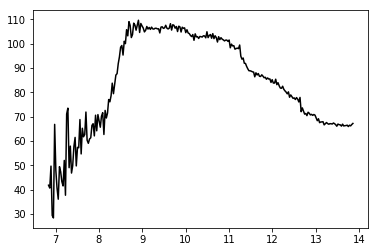

In [8]:
plt.plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')

In [11]:
vv = veloc_ang*2*np.pi/360.*1.0219051207939474
print vv[-1]

67.20898078845921


In [34]:
data = np.loadtxt('../_data/correcciones/lbar_time_GD.dat')
time_M31gd  = data[:,0]
lbar1_M31gd = data[:,1]
lbar2_M31gd = data[:,2]
lbar3_M31gd = data[:,3]
lbar4_M31gd = data[:,4]

data = np.loadtxt('../_data/correcciones/lbar_time_GS_001.dat')
time_M31gs  = data[:,0]
lbar1_M31gs = data[:,1]
lbar2_M31gs = data[:,2]
lbar3_M31gs = data[:,3]
lbar4_M31gs = data[:,4]

data = np.loadtxt('../_data/correcciones/lbar_time_GS_002.dat')
time_MWgs  = data[:,0]
lbar1_MWgs = data[:,1]
lbar2_MWgs = data[:,2]
lbar3_MWgs = data[:,3]
lbar4_MWgs = data[:,4]

In [48]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
import tenform as ten
import elipsoide as elip


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
atime = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = atime[:,2]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'



path = '/mnt/is2/alejandro/ornella/'
snapshot=range(496,300,-1)
k = 0
for isnap in snapshot:
    
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
#     halos = (0,1,3)
    # for i in halos:
    j = 0
    cm   = snap['subhalo_'+ str('%03d' %j) + '/Center'][()]
    r200 = snap['subhalo_'+ str('%03d' %j) + '/R200'][()]

    pstr = snap['subhalo_'+ str('%03d' %j) + '/Str/Coordinates'][()]
    IDs  = snap['subhalo_'+ str('%03d' %j) + '/Str/Ids'][()]
    mstr = snap['subhalo_'+ str('%03d' %j) + '/Str/Masses'][()]
    vel  = snap['subhalo_'+ str('%03d' %j) + '/Str/Velocities'][()]

    pgas = snap['subhalo_'+ str('%03d' %j) + '/Gas/Coordinates'][()]
    mgas = snap['subhalo_'+ str('%03d' %j) + '/Gas/Masses'][()]

    pdrk = snap['subhalo_'+ str('%03d' %j) + '/Drk/Coordinates'][()]
    mdrk = snap['subhalo_'+ str('%03d' %j) + '/Drk/Masses'][()]

    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time = tiempo.conv(z, h, omega_lambda, omega_matter)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    #----------------------masas----------------------------
    mstr = mstr/h
    mgas = mgas/h
    mdrk = mdrk/h

    r200 = r200*aexp[isnap]/h
    rgal = 0.15*r200

    limit = np.where(rstr<rgal)
    r_sort = np.sort(rstr[limit])
    r_indice = np.argsort(rstr[limit])

    Mc_str = np.cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    cincuenta, = np.where(razon < 0.5)

    r50 = r_sort[cincuenta][-1]              

    #------------------masa total en r200 (Mvir)--------------------------         
    veloc,=np.where(rstr<r50)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    #------------------------------------------------------------------
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<r200)
    rtot_sort   = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

    Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)


    #-----------------------------------------------------------------------
    #-----OMEGA BAR---------------------------------------------------------
    #-----------------------------------------------------------------------
    Rn = np.sqrt(xn**2 + yn**2)

    Vtg = (-yn*vxn + xn*vyn)/Rn

    omega = Vtg/Rn

    #-----Omega_bar 1---------------------------------------------------------

    mask_supreme, = np.where((Rn<3.*aexp[isnap]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]))

    nbin=20
    med, nodos = bine.rbin1(Rn[mask_supreme],nbin)

    omega_mean   = np.zeros(nbin)

    for i in range(0,nbin):
        mask, = np.where((Rn[mask_supreme] > nodos[i]) & (Rn[mask_supreme] < nodos[i+1]))

        omega_mean[i] = np.mean(omega[mask_supreme][mask])

    finterp1 = sint.interp1d(med,omega_mean,fill_value="extrapolate")
    
#     if lbar2_M31gd[k] == np.nan:
#         omegabar21 = np.nan
#     else:
#         omegabar21 = finterp1(lbar2_M31gd[k])
        
    omegabar11 = finterp1(lbar1_M31gd[k])
    omegabar21 = finterp1(lbar2_M31gd[k])
    omegabar31 = finterp1(lbar3_M31gd[k])
    omegabar41 = finterp1(lbar4_M31gd[k])

#     print 'omega_bar11 = ', omegabar11
#     print 'omega_bar21 = ', omegabar21
#     print 'omega_bar31 = ', omegabar31
#     print 'omega_bar41 = ', omegabar41


    #-----Omega_bar 2---------------------------------------------------------

    Rn = np.sqrt(xn**2 + yn**2)
    rn = np.sqrt(xn**2 + yn**2 + zn**2)
    Vtg = (-yn*vxn + xn*vyn)/Rn

    omega = Vtg/Rn

    mask_s2 = np.where(rn < 3*aexp[isnap])

    nbin=20
    med, nodos = bine.rbin1(rn[mask_s2],nbin)

    omega_mean   = np.zeros(nbin)

    for i in range(0,nbin):
        mask, = np.where((rn[mask_s2] > nodos[i]) & (rn[mask_s2] < nodos[i+1]))

        omega_mean[i] = np.mean(omega[mask_s2][mask])

    finterp2 = sint.interp1d(med,omega_mean,fill_value="extrapolate")
    
#     if lbar2_M31gd[k] == np.nan:
#         omegabar22 = np.nan
#     else:
#         omegabar22 = finterp2(lbar2_M31gd[k])
        
    omegabar12 = finterp2(lbar1_M31gd[k])
    omegabar22 = finterp2(lbar2_M31gd[k])
    omegabar32 = finterp2(lbar3_M31gd[k])
    omegabar42 = finterp2(lbar4_M31gd[k])

#     print 'omega_bar12 = ', omegabar12
#     print 'omega_bar22 = ', omegabar22
#     print 'omega_bar32 = ', omegabar32
#     print 'omega_bar42 = ', omegabar42

    #-----Omega_bar 3---------------------------------------------------------

    omegabar13 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,lbar1_M31gd[k])
    omegabar23 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,lbar2_M31gd[k])
    omegabar33 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,lbar3_M31gd[k])
    omegabar43 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,lbar4_M31gd[k])
  
    k=k+1
    #-----------------------------------------------------------------------
    #---- Rcorot -----------------------------------------------------------
    #-----------------------------------------------------------------------

    omega_circ= Vtot/rtot_sort

    interp  = sint.interp1d(omega_circ,rtot_sort,fill_value="extrapolate")
    
#     if omegabar21 == np.nan:
#         rcorot21 = np.nan
#     else:
#         rcorot21 = interp(omegabar21)
    
    rcorot11 = interp(omegabar11)
    rcorot21 = interp(omegabar21)
    rcorot31 = interp(omegabar31)
    rcorot41 = interp(omegabar41)

#     print 'Rcorot11 = ', rcorot11
#     print 'Rcorot21 = ', rcorot21
#     print 'Rcorot31 = ', rcorot31
#     print 'Rcorot41 = ', rcorot41

#     if omegabar22 == np.nan:
#         rcorot22 = np.nan
#     else:
#         rcorot22 = interp(omegabar22)
        
    rcorot12 = interp(omegabar12)
    rcorot22 = interp(omegabar22)
    rcorot32 = interp(omegabar32)
    rcorot42 = interp(omegabar42)

#     print 'Rcorot12 = ', rcorot12
#     print 'Rcorot22 = ', rcorot22
#     print 'Rcorot32 = ', rcorot32
#     print 'Rcorot42 = ', rcorot42

#     if omegabar23 == np.nan:
#         rcorot23 = np.nan
#     else:
#         rcorot23 = interp(omegabar23)
        
    rcorot13 = interp(omegabar13)
    rcorot23 = interp(omegabar23)
    rcorot33 = interp(omegabar33)
    rcorot43 = interp(omegabar43)

#     print 'Rcorot13 = ', rcorot13
#     print 'Rcorot23 = ', rcorot23
#     print 'Rcorot33 = ', rcorot33
#     print 'Rcorot43 = ', rcorot43

    archivo = open(path2 + 'omega_time_GD2.dat','a')
    archivo.write(str('%12.8f'% time) +'\t'+
                str('%12.8f'% omegabar11) +'\t'+
                str('%12.8f'% omegabar21) +'\t'+
                str('%12.8f'% omegabar31) +'\t'+
                str('%12.8f'% omegabar41) +'\t'+
                str('%12.8f'% omegabar12) +'\t'+
                str('%12.8f'% omegabar22) +'\t'+
                str('%12.8f'% omegabar32) +'\t'+
                str('%12.8f'% omegabar42) +'\t'+
                str('%12.8f'% omegabar13) +'\t'+
                str('%12.8f'% omegabar23) +'\t'+
                str('%12.8f'% omegabar33) +'\t'+
                str('%12.8f'% omegabar43) +'\n')
    archivo.close()
    
    archivo2 = open(path2 + 'rcorot_time_GD2.dat','a')
    archivo2.write( str('%12.8f'% time) +'\t'+
                   str('%12.8f'% rcorot11) +'\t'+
                   str('%12.8f'% rcorot21) +'\t'+
                   str('%12.8f'% rcorot31) +'\t'+
                   str('%12.8f'% rcorot41) +'\t'+
                   str('%12.8f'% rcorot12) +'\t'+
                   str('%12.8f'% rcorot22) +'\t'+
                   str('%12.8f'% rcorot32) +'\t'+
                   str('%12.8f'% rcorot42) +'\t'+
                   str('%12.8f'% rcorot13) +'\t'+
                   str('%12.8f'% rcorot23) +'\t'+
                   str('%12.8f'% rcorot33) +'\t'+
                   str('%12.8f'% rcorot43) +'\n')
    archivo2.close()
    
## el numero 2 esta calculada con el elipsoide usando los ejes del tensor de forma.
## el que no tiene numero esta calculado el omega rotando el phimax (puede que este inclinado por eso lo cambiamos)

/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in divide
/home/omarioni/miniconda2/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [49]:
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'

GADGET = np.loadtxt(path+'omega_time_GD.dat')
time    = GADGET[:,0]
omega11 = GADGET[:,1]
omega21 = GADGET[:,2]
omega31 = GADGET[:,3]
omega41 = GADGET[:,4]
omega12 = GADGET[:,5]
omega22 = GADGET[:,6]
omega32 = GADGET[:,7]
omega42 = GADGET[:,8]
omega13 = GADGET[:,9]
omega23 = GADGET[:,10]
omega33 = GADGET[:,11]
omega43 = GADGET[:,12]

GADGET2 = np.loadtxt(path+'omega_time_GD2.dat')
time_    = GADGET2[:,0]
omega13_ = GADGET2[:,9]
omega23_ = GADGET2[:,10]
omega33_ = GADGET2[:,11]
omega43_ = GADGET2[:,12]


Text(0.5,1,'lbar4 - perfiles')

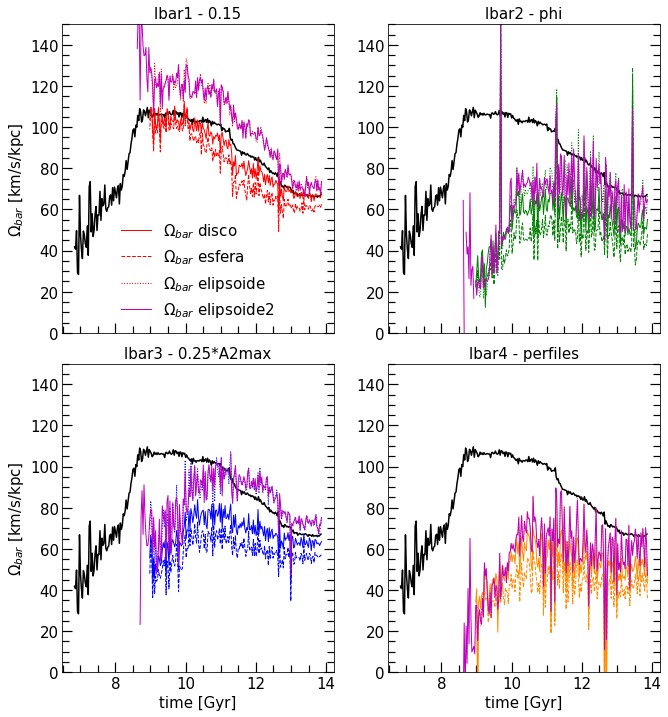

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0.2, hspace= 0.1)

ax[0,0].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[0,0].plot(time,omega11, color='r', lw=1, label='$\Omega_{bar}$ disco')
ax[0,0].plot(time,omega12, color='r', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[0,0].plot(time,omega13, color='r', lw=1, ls=':', label='$\Omega_{bar}$ elipsoide')
ax[0,0].plot(time_,omega13_,color='m', lw=1, ls='-', label='$\Omega_{bar}$ elipsoide2')
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=15)
ax[0,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[0,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax[0,0].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
# ax[0,0].set_xlabel('time [Gyr]',fontsize=15)
ax[0,0].set_ylim(0,150)
ax[0,0].set_title('lbar1 - 0.15', fontsize=15)
ax[0,0].legend(fontsize=15,frameon=False)

ax[0,1].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[0,1].plot(time,omega21, color='g', lw=1, label='$\Omega_{bar}$ disco')
ax[0,1].plot(time,omega22, color='g', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[0,1].plot(time,omega23, color='g', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[0,1].plot(time_,omega23_,color='m', lw=1, ls='-',label='$\Omega_{bar}$ elipsoide2')
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=15)
ax[0,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[0,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax[0,1].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
# ax[0,1].set_xlabel('time [Gyr]',fontsize=15)
ax[0,1].set_ylim(0,150)
ax[0,1].set_title('lbar2 - phi', fontsize=15)
# ax[0,1].legend(fontsize=15,frameon=False)

ax[1,0].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[1,0].plot(time,omega31, color='b', lw=1, label='$\Omega_{bar}$ disco')
ax[1,0].plot(time,omega32, color='b', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[1,0].plot(time,omega33, color='b', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1,0].plot(time_,omega33_,color='m', lw=1, ls='-',label='$\Omega_{bar}$ elipsoide2')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=15)
ax[1,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[1,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax[1,0].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[1,0].set_xlabel('time [Gyr]',fontsize=15)
ax[1,0].set_ylim(0,150)
ax[1,0].set_title('lbar3 - 0.25*A2max', fontsize=15)
# ax[1,0].legend(fontsize=15,frameon=False)

ax[1,1].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[1,1].plot(time,omega41, color='darkorange', lw=1, label='$\Omega_{bar}$ disco')
ax[1,1].plot(time,omega42, color='darkorange', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[1,1].plot(time,omega43, color='darkorange', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1,1].plot(time_,omega43_,color='m', lw=1, ls='-',label='$\Omega_{bar}$ elipsoide')
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=15)
ax[1,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[1,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax[1,1].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[1,1].set_xlabel('time [Gyr]',fontsize=15)
ax[1,1].set_ylim(0,150)
ax[1,1].set_title('lbar4 - perfiles', fontsize=15)
# ax[1,1].legend(fontsize=15,frameon=False)

In [3]:
import numpy as np
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'

GADGET = np.loadtxt(path+'lbar_set_GD.dat')
M31gd_lbar1 = GADGET[0,1]
M31gd_lbar2 = GADGET[0,2]
M31gd_lbar3 = GADGET[0,3]
M31gd_lbar4 = GADGET[0,4]

GASOLINE = np.loadtxt(path+'lbar_set_GS.dat')
M31gs_lbar1 = GASOLINE[0,1]
M31gs_lbar2 = GASOLINE[0,2]
M31gs_lbar3 = GASOLINE[0,3]
M31gs_lbar4 = GASOLINE[0,4]

MWgs_lbar1 = GASOLINE[1,1]
MWgs_lbar2 = GASOLINE[1,2]
MWgs_lbar3 = GASOLINE[1,3]
MWgs_lbar4 = GASOLINE[1,4]

In [6]:
%%time
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import barstrength2 as strng
import bines2 as bine
import elipsoide as elip
import scipy.interpolate as sint

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
atime = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = atime[:,2]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
# archivo = open(path2 + 'omega_set_GD.dat','a')


path = '/mnt/is2/alejandro/ornella/'
# snapshot=range(496,300,-1)
# for isnap in snapshot:

isnap = 496
snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
halos = (0,1,3)

# for i in halos:
i = 0
cm   = snap['subhalo_'+ str('%03d' %i) + '/Center'][()]
r200 = snap['subhalo_'+ str('%03d' %i) + '/R200'][()]

pstr = snap['subhalo_'+ str('%03d' %i) + '/Str/Coordinates'][()]
IDs  = snap['subhalo_'+ str('%03d' %i) + '/Str/Ids'][()]
mstr = snap['subhalo_'+ str('%03d' %i) + '/Str/Masses'][()]
vel  = snap['subhalo_'+ str('%03d' %i) + '/Str/Velocities'][()]

pgas = snap['subhalo_'+ str('%03d' %i) + '/Gas/Coordinates'][()]
mgas = snap['subhalo_'+ str('%03d' %i) + '/Gas/Masses'][()]

pdrk = snap['subhalo_'+ str('%03d' %i) + '/Drk/Coordinates'][()]
mdrk = snap['subhalo_'+ str('%03d' %i) + '/Drk/Masses'][()]

z = a0/aexp[isnap] - 1.
Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
# time = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
mstr = mstr/h
mgas = mgas/h
mdrk = mdrk/h

r200 = r200*aexp[isnap]/h
rgal = 0.15*r200

limit = np.where(rstr<rgal)
r_sort = np.sort(rstr[limit])
r_indice = np.argsort(rstr[limit])

Mc_str = np.cumsum((mstr[limit])[r_indice])
M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
razon = Mc_str/M_gal
cincuenta, = np.where(razon < 0.5)

r50 = r_sort[cincuenta][-1]              

#------------------masa total en r200 (Mvir)--------------------------         
veloc,=np.where(rstr<r50)

#----------componentes de la velocidad del centro de masa------------
vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

#------------------------------------------------------------------
rtot = np.concatenate([rstr, rgas, rdrk])
mtot = np.concatenate([mstr, mgas, mdrk])

limit_tot   = np.where(rtot<r200)
rtot_sort   = np.sort(rtot[limit_tot])
rtot_indice = np.argsort(rtot[limit_tot])

Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)


print 'lbar1 = ', M31gd_lbar1
print 'lbar2 = ', M31gd_lbar2
print 'lbar3 = ', M31gd_lbar3
print 'lbar4 = ', M31gd_lbar4, '\n'


#-----------------------------------------------------------------------
#-----OMEGA BAR---------------------------------------------------------
#-----------------------------------------------------------------------
Rn = np.sqrt(xn**2 + yn**2)

Vtg = (-yn*vxn + xn*vyn)/Rn

omega = Vtg/Rn

#-----Omega_bar 1---------------------------------------------------------

mask_supreme, = np.where((Rn<3.*aexp[isnap]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]))

nbin=20
med, nodos = bine.rbin1(Rn[mask_supreme],nbin)

omega_mean   = np.zeros(nbin)

for i in range(0,nbin):
    mask, = np.where((Rn[mask_supreme] > nodos[i]) & (Rn[mask_supreme] < nodos[i+1]))

    omega_mean[i] = np.mean(omega[mask_supreme][mask])

finterp1 = sint.interp1d(med,omega_mean,fill_value="extrapolate")

omegabar11 = finterp1(M31gd_lbar1)
omegabar21 = finterp1(M31gd_lbar2)
omegabar31 = finterp1(M31gd_lbar3)
omegabar41 = finterp1(M31gd_lbar4)

print 'omega_bar11 = ', omegabar11
print 'omega_bar21 = ', omegabar21
print 'omega_bar31 = ', omegabar31
print 'omega_bar41 = ', omegabar41, '\n'


#-----Omega_bar 2---------------------------------------------------------

Rn = np.sqrt(xn**2 + yn**2)
rn = np.sqrt(xn**2 + yn**2 + zn**2)
Vtg = (-yn*vxn + xn*vyn)/Rn

omega = Vtg/Rn

mask_s2 = np.where(rn < 3*aexp[isnap])

nbin=20
med, nodos = bine.rbin1(rn[mask_s2],nbin)

omega_mean   = np.zeros(nbin)

for i in range(0,nbin):
    mask, = np.where((rn[mask_s2] > nodos[i]) & (rn[mask_s2] < nodos[i+1]))

    omega_mean[i] = np.mean(omega[mask_s2][mask])

finterp2 = sint.interp1d(med,omega_mean,fill_value="extrapolate")

omegabar12 = finterp2(M31gd_lbar1)
omegabar22 = finterp2(M31gd_lbar2)
omegabar32 = finterp2(M31gd_lbar3)
omegabar42 = finterp2(M31gd_lbar4)

print 'omega_bar12 = ', omegabar12
print 'omega_bar22 = ', omegabar22
print 'omega_bar32 = ', omegabar32
print 'omega_bar42 = ', omegabar42, '\n'

#-----Omega_bar 3---------------------------------------------------------
corte2, = np.where(rn<3*aexp[isnap])
A2max, rmax, phimax = strng.a2max(mstr[corte2], xn[corte2], yn[corte2], 20)

omegabar13, xn1, yn1, zn1, autovec1, A1, B1, C1 = elip.elipsoide(xn,yn,zn,vxn,vyn,vzn,M31gd_lbar1, phimax)
omegabar23, xn2, yn2, zn2, autovec2, A2, B2, C2 = elip.elipsoide(xn,yn,zn,vxn,vyn,vzn,M31gd_lbar2, phimax)
omegabar33, xn3, yn3, zn3, autovec3, A3, B3, C3 = elip.elipsoide(xn,yn,zn,vxn,vyn,vzn,M31gd_lbar3, phimax)
omegabar43, xn4, yn4, zn4, autovec4, A4, B4, C4 = elip.elipsoide(xn,yn,zn,vxn,vyn,vzn,M31gd_lbar4, phimax)


print 'omega_bar13 = ', omegabar13
print 'omega_bar23 = ', omegabar23
print 'omega_bar33 = ', omegabar33
print 'omega_bar43 = ', omegabar43, '\n'

print 'V1', autovec1
print 'V2', autovec2
print 'V3', autovec3
print 'V4', autovec4, '\n'

print 'A1=', A1, 'B1=', B1, 'C1=', C1
print 'A2=', A2, 'B2=', B2, 'C2=', C2
print 'A3=', A3, 'B3=', B3, 'C3=', C3
print 'A4=', A4, 'B4=', B4, 'C4=', C4, '\n'


# omegabar13n, xn1n, yn1n, zn1n, V11, V21, V31, A1, B1, C1 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar1)
# omegabar23n, xn2n, yn2n, zn2n, V12, V22, V32, A2, B2, C2 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar2)
# omegabar33n, xn3n, yn3n, zn3n, V13, V23, V33, A3, B3, C3 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar3)
# omegabar43n, xn4n, yn4n, zn4n, V14, V24, V34, A4, B4, C4 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar4)

omegabar13n = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar1)
omegabar23n = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar2)
omegabar33n = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar3)
omegabar43n = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar4)

print 'omega_bar13_new = ', omegabar13n
print 'omega_bar23_new = ', omegabar23n
print 'omega_bar33_new = ', omegabar33n
print 'omega_bar43_new = ', omegabar43n, '\n'

# print 'V1', V11, V21, V31
# print 'V2', V12, V22, V32
# print 'V3', V13, V23, V33
# print 'V4', V14, V24, V34, '\n'

# print 'A1=', A1, 'B1=', B1, 'C1=', C1
# print 'A2=', A2, 'B2=', B2, 'C2=', C2
# print 'A3=', A3, 'B3=', B3, 'C3=', C3
# print 'A4=', A4, 'B4=', B4, 'C4=', C4, '\n'
#-----------------------------------------------------------------------
#---- Rcorot -----------------------------------------------------------
#-----------------------------------------------------------------------

omega_circ= Vtot/rtot_sort

interp  = sint.interp1d(omega_circ,rtot_sort,fill_value="extrapolate")
rcorot11 = interp(omegabar11)
rcorot21 = interp(omegabar21)
rcorot31 = interp(omegabar31)
rcorot41 = interp(omegabar41)

print 'Rcorot11 = ', rcorot11
print 'Rcorot21 = ', rcorot21
print 'Rcorot31 = ', rcorot31
print 'Rcorot41 = ', rcorot41, '\n'


rcorot12 = interp(omegabar12)
rcorot22 = interp(omegabar22)
rcorot32 = interp(omegabar32)
rcorot42 = interp(omegabar42)

print 'Rcorot12 = ', rcorot12
print 'Rcorot22 = ', rcorot22
print 'Rcorot32 = ', rcorot32
print 'Rcorot42 = ', rcorot42, '\n'


rcorot13 = interp(omegabar13)
rcorot23 = interp(omegabar23)
rcorot33 = interp(omegabar33)
rcorot43 = interp(omegabar43)

print 'Rcorot13 = ', rcorot13
print 'Rcorot23 = ', rcorot23
print 'Rcorot33 = ', rcorot33
print 'Rcorot43 = ', rcorot43, '\n'


lbar1 =  1.39687181
lbar2 =  1.93518513
lbar3 =  1.53419664
lbar4 =  2.30243405 

omega_bar11 =  68.3845776035314
omega_bar21 =  52.143157623213774
omega_bar31 =  63.778475733834036
omega_bar41 =  43.58592667664339 

omega_bar12 =  62.52076276366192
omega_bar22 =  44.82518104857742
omega_bar32 =  57.266902635155475
omega_bar42 =  36.320078933806336 

omega_bar13 =  73.28226404672168
omega_bar23 =  64.64094663191557
omega_bar33 =  75.28249385656059
omega_bar43 =  47.75696978662623 

V1 [[ 0.99991051 -0.0124597  -0.00487069]
 [-0.01250032 -0.99988659 -0.00839914]
 [ 0.00476548 -0.00845928  0.99995286]]
V2 [[ 0.99996744  0.00741337  0.00318807]
 [ 0.00740637 -0.99997014  0.00220481]
 [-0.00320432  0.00218113  0.99999249]]
V3 [[ 0.99994839 -0.0096931  -0.00304184]
 [-0.00970983 -0.99993755 -0.00553334]
 [ 0.00298802 -0.00556259  0.99998006]]
V4 [[ 0.9997579   0.01992517  0.00933406]
 [ 0.01980885 -0.99972698  0.01239265]
 [-0.00957843  0.01220475  0.99987964]] 

A1= 0.5049168051548275 B1= 

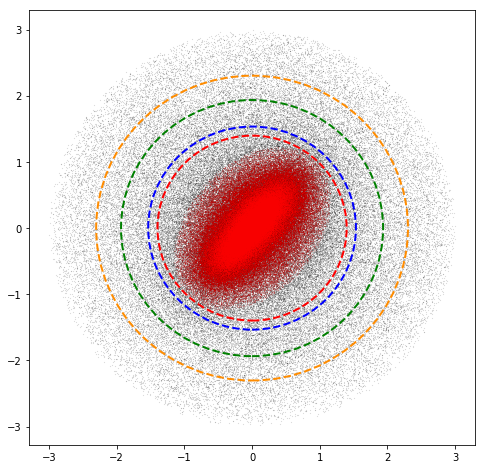

In [6]:
import matplotlib.patches as patches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(xn[np.where(rn<3.)],yn[np.where(rn<3.)],'.k',markersize=0.1)
ax.plot(xn1,yn1,'.r',markersize=0.1)
circ1 = patches.Circle((0., 0.), M31gd_lbar1, fc='None',ec='r',ls='--',lw=2,zorder=10)
circ2 = patches.Circle((0., 0.), M31gd_lbar2, fc='None',ec='g',ls='--',lw=2,zorder=10)
circ3 = patches.Circle((0., 0.), M31gd_lbar3, fc='None',ec='b',ls='--',lw=2,zorder=10)
circ4 = patches.Circle((0., 0.), M31gd_lbar4, fc='None',ec='darkorange',ls='--',lw=2,zorder=10)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)

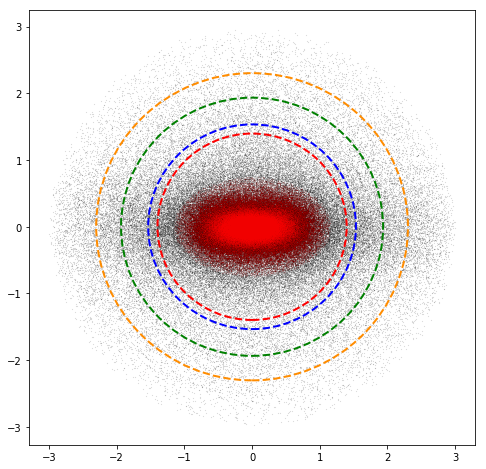

In [12]:
import matplotlib.patches as patches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(xn[np.where(rn<3.)],zn[np.where(rn<3.)],'.k',markersize=0.1)
ax.plot(xn1,zn1,'.r',markersize=0.1,alpha=0.5)
circ1 = patches.Circle((0., 0.), M31gd_lbar1, fc='None',ec='r',ls='--',lw=2,zorder=10)
circ2 = patches.Circle((0., 0.), M31gd_lbar2, fc='None',ec='g',ls='--',lw=2,zorder=10)
circ3 = patches.Circle((0., 0.), M31gd_lbar3, fc='None',ec='b',ls='--',lw=2,zorder=10)
circ4 = patches.Circle((0., 0.), M31gd_lbar4, fc='None',ec='darkorange',ls='--',lw=2,zorder=10)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)

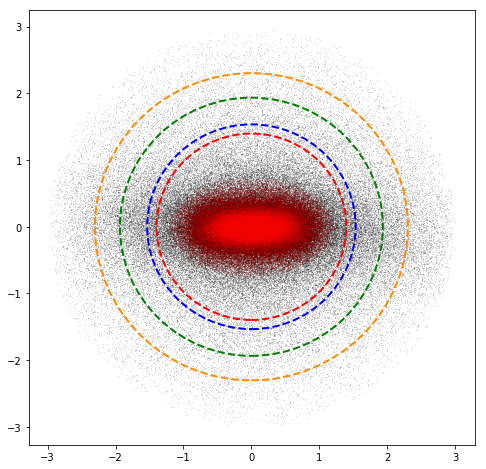

In [13]:
import matplotlib.patches as patches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(yn[np.where(rn<3.)],zn[np.where(rn<3.)],'.k',markersize=0.1)
ax.plot(yn1,zn1,'.r',markersize=0.1,alpha=0.5)
circ1 = patches.Circle((0., 0.), M31gd_lbar1, fc='None',ec='r',ls='--',lw=2,zorder=10)
circ2 = patches.Circle((0., 0.), M31gd_lbar2, fc='None',ec='g',ls='--',lw=2,zorder=10)
circ3 = patches.Circle((0., 0.), M31gd_lbar3, fc='None',ec='b',ls='--',lw=2,zorder=10)
circ4 = patches.Circle((0., 0.), M31gd_lbar4, fc='None',ec='darkorange',ls='--',lw=2,zorder=10)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)

In [47]:
## Calculamos las particulas dentro de un elipsoide de semieje mayor = radio
## el angulo es el phi, es para alinear el semieje mayor con el eje x
from goto import with_goto
import numpy as np
import tenform as ten
import bines2 as bine
import scipy.interpolate as sint
@with_goto
def elipsoide2(x,y,z,vx,vy,vz,m,radio, nbin=20):
    

    if np.isnan(radio)== True:
        omegabar = np.nan
        goto .end
    
    r = np.sqrt(x**2 + y**2 + z**2)

    limit, = np.where(r < radio)
    
    jx = sum(m[limit]*(y[limit]*vz[limit]-z[limit]*vy[limit]))
    jy = sum(m[limit]*(z[limit]*vx[limit]-x[limit]*vz[limit]))
    jz = sum(m[limit]*(x[limit]*vy[limit]-y[limit]*vx[limit]))

    j = np.sqrt(jx**2 + jy**2 + jz**2)
    Jt = np.ndarray(3)
    Jt[0] = jx
    Jt[1] = jy
    Jt[2] = jz
    
    tensor   = ten.tenf(x[limit], y[limit], z[limit]) #calculo el tensor de forma
    matriz   = np.linalg.eig(tensor) #saco los autovalores
    autoval  = matriz[0]
    autovec  = matriz[1]

    asort  = np.argsort(autoval) #los ordeno de menor a mayor

    A = np.sqrt(autoval[asort][2]) #semiejes
    B = np.sqrt(autoval[asort][1])
    C = np.sqrt(autoval[asort][0])
    
    V1 = autovec[:,asort][:,2] 
    V2 = autovec[:,asort][:,1]
    V3 = autovec[:,asort][:,0]
    
    
    modV = np.sqrt(np.dot(V3,V3))
    tita = np.arccos(np.dot(Jt,V3)/(j*modV))
    
    if tita > np.pi/2.:
        V3 = -V3
        
    cruz = np.cross(V3,V1)
    test = np.sign(cruz) == np.sign(V2)
    if test.all() == False:
        V2 = cruz

    aa = radio #normalizo al radio que yo quiero
    bb = (B/A)*radio
    cc = (C/A)*radio
    
    pos = np.ndarray([len(x[limit]),3])
    pos[:,0] = x[limit]
    pos[:,1] = y[limit]
    pos[:,2] = z[limit]
    
    xx = np.zeros(len(x[limit]))
    yy = np.zeros(len(x[limit]))
    zz = np.zeros(len(x[limit]))
    
    xx[:] = np.dot(pos[:],V1)
    yy[:] = np.dot(pos[:],V2)
    zz[:] = np.dot(pos[:],V3)

    Relip = np.sqrt((xx/aa)**2 + (yy/bb)**2 + (zz/cc)**2) # formula del elipsoide
    mask, = np.where(Relip <= 1.)

    xn  = xx[mask]
    yn  = yy[mask]
    zn  = zz[mask]
    
    vel = np.ndarray([len(x[limit]),3])
    vel[:,0] = vx[limit]
    vel[:,1] = vy[limit]
    vel[:,2] = vz[limit]
    
    vxx = np.zeros(len(x[limit]))
    vyy = np.zeros(len(x[limit]))
    vzz = np.zeros(len(x[limit]))
    
    vxx[:] = np.dot(vel[:],V1)
    vyy[:] = np.dot(vel[:],V2)
    vzz[:] = np.dot(vel[:],V3)
    
    vxn = vxx[mask]
    vyn = vyy[mask]
    vzn = vzz[mask]

    rn = np.sqrt(xn**2 + yn**2 + zn**2)
    Rn = np.sqrt(xn**2 + yn**2)

    Vtg = (-yn*vxn + xn*vyn)/Rn

    omega = Vtg/Rn

    med, nodos = bine.rbin1(rn,nbin)
    omega_mean = np.zeros(nbin)

    for i in range(0,nbin):
        inbin, = np.where((rn > nodos[i]) & (rn < nodos[i+1]))

        omega_mean[i] = np.mean(omega[inbin])

    finterp = sint.interp1d(med,omega_mean,fill_value="extrapolate")

    omegabar = finterp(radio)
    
    label .end
    return omegabar #xn, yn, zn, V1, V2, V3, A, B, C